In [2]:
import os

images_dir = "/kaggle/input/segmentation/images-20251230T160417Z-3-001/images"
masks_dir  = "/kaggle/input/segmentation/masks-20251230T160416Z-3-001/masks"

image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(".png")])
mask_files  = sorted([f for f in os.listdir(masks_dir) if f.endswith(".png")])

print("Images:", len(image_files))
print("Masks :", len(mask_files))

# Build expected mask names
expected_masks = [f.replace(".png", "_Annotation.png") for f in image_files]

missing_masks = [m for m in expected_masks if m not in mask_files]

print("\nMissing masks for:")
print(missing_masks[:10], "..." if len(missing_masks) > 10 else "")

print("\nStatus:", "OK  All masks matched"
      if len(missing_masks) == 0 else " Some masks are missing")


Images: 622
Masks : 622

Missing masks for:
[] 

Status: OK  All masks matched


In [3]:
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
from torchvision import transforms
from PIL import Image
from torchvision.transforms import functional as TF

class FetalHeadDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(".png")])

    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        mask_name = img_name.replace(".png", "_Annotation.png")

        image = Image.open(os.path.join(self.images_dir, img_name)).convert("L")
        mask  = Image.open(os.path.join(self.masks_dir, mask_name)).convert("L")

        mask = np.array(mask)

        # binarize
        _, mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)

        # find and fill contour
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        filled = np.zeros_like(mask)
        cv2.drawContours(filled, contours, -1, 255, thickness=-1)

        mask = Image.fromarray(filled)


        # Resize
        image = TF.resize(image, (512, 512), interpolation=TF.InterpolationMode.BILINEAR)
        mask  = TF.resize(mask,  (512, 512), interpolation=TF.InterpolationMode.NEAREST)

        # Horizontal flip
        if np.random.rand() < 0.5:
            image = TF.hflip(image)
            mask  = TF.hflip(mask)
        
        # Small rotation (important for ultrasound)
        if np.random.rand() < 0.5:
            angle = np.random.uniform(-10, 10)
            image = TF.rotate(image, angle)
            mask  = TF.rotate(mask, angle, interpolation=TF.InterpolationMode.NEAREST)



        image = TF.to_tensor(image)
        mean = image.mean()
        std  = image.std()
        image = (image - image.mean()) / (image.std() + 1e-6)


        # binary mask 0/1
        mask = TF.to_tensor(mask)
        mask = (mask > 0.5).float()

        return image, mask
 
# ---- transforms ----
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset = FetalHeadDataset(images_dir, masks_dir, transform=transform)

print("Total samples:", len(dataset))

# test one sample
img, msk = dataset[0]
print("Image shape:", img.shape)
print("Mask shape :", msk.shape, " Mask min/max:", msk.min().item(), msk.max().item())


Total samples: 622
Image shape: torch.Size([1, 512, 512])
Mask shape : torch.Size([1, 512, 512])  Mask min/max: 0.0 1.0


In [4]:
from torch.utils.data import random_split, DataLoader

train_ratio = 0.85
train_size = int(train_ratio * len(dataset))
val_size   = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print("Train samples :", len(train_dataset))
print("Val samples   :", len(val_dataset))


# ---- DataLoaders ----
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)

# test one batch
images, masks = next(iter(train_loader))
print("Batch image shape:", images.shape)
print("Batch mask shape :", masks.shape)

Train samples : 528
Val samples   : 94
Batch image shape: torch.Size([8, 1, 512, 512])
Batch mask shape : torch.Size([8, 1, 512, 512])


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# -------- Encoder Block --------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


# -------- U-Net Model --------
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.down1 = DoubleConv(1, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.output = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        c1 = self.down1(x)
        p1 = self.pool(c1)

        c2 = self.down2(p1)
        p2 = self.pool(c2)

        c3 = self.down3(p2)
        p3 = self.pool(c3)

        c4 = self.down4(p3)
        p4 = self.pool(c4)

        bn = self.bottleneck(p4)

        u4 = self.up4(bn)
        u4 = torch.cat([u4, c4], dim=1)
        c4 = self.conv4(u4)

        u3 = self.up3(c4)
        u3 = torch.cat([u3, c3], dim=1)
        c3 = self.conv3(u3)

        u2 = self.up2(c3)
        u2 = torch.cat([u2, c2], dim=1)
        c2 = self.conv2(u2)

        u1 = self.up1(c2)
        u1 = torch.cat([u1, c1], dim=1)
        c1 = self.conv1(u1)

        return torch.sigmoid(self.output(c1))


# ---- Create model ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

print("Model loaded on:", device)


Model loaded on: cuda


In [5]:
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3):
        super().__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, pred, target, eps=1e-6):
        tp = (pred * target).sum()
        fp = ((1-target) * pred).sum()
        fn = (target * (1-pred)).sum()
        tversky = (tp + eps) / (tp + self.alpha*fp + self.beta*fn + eps)
        return 1 - tversky


class FocalDiceLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma

    def forward(self, pred, target, eps=1e-6):
        intersection = (pred * target).sum()
        dice = (2*intersection + eps) / (pred.sum() + target.sum() + eps)
        return (1 - dice) ** self.gamma

In [6]:
import torch.optim as optim

# ---- Dice Score ----
def dice_score(pred, target, eps=1e-6):
    # soft dice (no threshold)
    intersection = (pred * target).sum()
    return (2 * intersection + eps) / (pred.sum() + target.sum() + eps)


# ---- Dice Loss ----
class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, target, eps=1e-6):
        intersection = (pred * target).sum()
        dice = (2 * intersection + eps) / (pred.sum() + target.sum() + eps)
        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss()

    def forward(self, preds, targets):
        preds = preds.contiguous()
        targets = targets.contiguous()

        bce = self.bce(preds, targets)

        smooth = 1e-6
        intersection = (preds * targets).sum()
        dice = (2. * intersection + smooth) / (
            preds.sum() + targets.sum() + smooth)

        return bce + (1 - dice)

# ---- Optimizer ----
optimizer = optim.Adam(model.parameters(), lr=1e-4)

criterion = DiceBCELoss()   
print("Loss + optimizer ready ")

Loss + optimizer ready 


In [7]:
from tqdm import tqdm

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_dice = 0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Train"):
        images = images.to(device)
        masks  = masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, masks)   

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice += dice_score(outputs, masks).item()

    train_loss /= len(train_loader)
    train_dice /= len(train_loader)


    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_dice = 0

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Val"):
            images = images.to(device)
            masks  = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            val_dice += dice_score(outputs, masks).item()

    val_loss /= len(val_loader)
    val_dice /= len(val_loader)

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Dice: {train_dice:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Dice: {val_dice:.4f}")
    print("-" * 50)

Epoch 1/20 - Val: 100%|██████████| 12/12 [00:06<00:00,  1.96it/s]



Epoch 1/20
Train Loss: 0.8513 | Train Dice: 0.5880
Val   Loss: 0.8128 | Val   Dice: 0.6641
--------------------------------------------------


Epoch 2/20 - Val: 100%|██████████| 12/12 [00:04<00:00,  2.46it/s]



Epoch 2/20
Train Loss: 0.5751 | Train Dice: 0.7048
Val   Loss: 0.6245 | Val   Dice: 0.7040
--------------------------------------------------


Epoch 3/20 - Val: 100%|██████████| 12/12 [00:04<00:00,  2.41it/s]



Epoch 3/20
Train Loss: 0.4926 | Train Dice: 0.7404
Val   Loss: 0.4978 | Val   Dice: 0.7328
--------------------------------------------------


Epoch 4/20 - Val: 100%|██████████| 12/12 [00:04<00:00,  2.48it/s]



Epoch 4/20
Train Loss: 0.4364 | Train Dice: 0.7671
Val   Loss: 0.4318 | Val   Dice: 0.7693
--------------------------------------------------


Epoch 5/20 - Val: 100%|██████████| 12/12 [00:04<00:00,  2.45it/s]



Epoch 5/20
Train Loss: 0.3829 | Train Dice: 0.7937
Val   Loss: 0.3768 | Val   Dice: 0.7955
--------------------------------------------------


Epoch 6/20 - Val: 100%|██████████| 12/12 [00:04<00:00,  2.43it/s]



Epoch 6/20
Train Loss: 0.3437 | Train Dice: 0.8138
Val   Loss: 0.3578 | Val   Dice: 0.8006
--------------------------------------------------


Epoch 7/20 - Val: 100%|██████████| 12/12 [00:04<00:00,  2.46it/s]



Epoch 7/20
Train Loss: 0.3202 | Train Dice: 0.8277
Val   Loss: 0.3395 | Val   Dice: 0.8211
--------------------------------------------------


Epoch 8/20 - Val: 100%|██████████| 12/12 [00:04<00:00,  2.46it/s]



Epoch 8/20
Train Loss: 0.2969 | Train Dice: 0.8398
Val   Loss: 0.2908 | Val   Dice: 0.8403
--------------------------------------------------


Epoch 9/20 - Val: 100%|██████████| 12/12 [00:04<00:00,  2.47it/s]



Epoch 9/20
Train Loss: 0.2736 | Train Dice: 0.8527
Val   Loss: 0.2732 | Val   Dice: 0.8558
--------------------------------------------------


Epoch 10/20 - Val: 100%|██████████| 12/12 [00:04<00:00,  2.45it/s]



Epoch 10/20
Train Loss: 0.2405 | Train Dice: 0.8701
Val   Loss: 0.2585 | Val   Dice: 0.8602
--------------------------------------------------


Epoch 11/20 - Val: 100%|██████████| 12/12 [00:04<00:00,  2.48it/s]



Epoch 11/20
Train Loss: 0.2305 | Train Dice: 0.8760
Val   Loss: 0.2590 | Val   Dice: 0.8649
--------------------------------------------------


Epoch 12/20 - Val: 100%|██████████| 12/12 [00:04<00:00,  2.42it/s]



Epoch 12/20
Train Loss: 0.2170 | Train Dice: 0.8841
Val   Loss: 0.2136 | Val   Dice: 0.8837
--------------------------------------------------


Epoch 13/20 - Val: 100%|██████████| 12/12 [00:04<00:00,  2.44it/s]



Epoch 13/20
Train Loss: 0.1975 | Train Dice: 0.8948
Val   Loss: 0.2134 | Val   Dice: 0.8886
--------------------------------------------------


Epoch 14/20 - Val: 100%|██████████| 12/12 [00:04<00:00,  2.46it/s]



Epoch 14/20
Train Loss: 0.1899 | Train Dice: 0.8993
Val   Loss: 0.2146 | Val   Dice: 0.8860
--------------------------------------------------


Epoch 15/20 - Val: 100%|██████████| 12/12 [00:04<00:00,  2.42it/s]



Epoch 15/20
Train Loss: 0.1829 | Train Dice: 0.9040
Val   Loss: 0.1989 | Val   Dice: 0.8957
--------------------------------------------------


Epoch 16/20 - Val: 100%|██████████| 12/12 [00:04<00:00,  2.44it/s]



Epoch 16/20
Train Loss: 0.1666 | Train Dice: 0.9123
Val   Loss: 0.1818 | Val   Dice: 0.9028
--------------------------------------------------


Epoch 17/20 - Val: 100%|██████████| 12/12 [00:04<00:00,  2.43it/s]



Epoch 17/20
Train Loss: 0.1594 | Train Dice: 0.9169
Val   Loss: 0.1701 | Val   Dice: 0.9113
--------------------------------------------------


Epoch 18/20 - Val: 100%|██████████| 12/12 [00:04<00:00,  2.45it/s]



Epoch 18/20
Train Loss: 0.1502 | Train Dice: 0.9220
Val   Loss: 0.1751 | Val   Dice: 0.9116
--------------------------------------------------


Epoch 19/20 - Val: 100%|██████████| 12/12 [00:04<00:00,  2.43it/s]



Epoch 19/20
Train Loss: 0.1498 | Train Dice: 0.9228
Val   Loss: 0.1828 | Val   Dice: 0.9118
--------------------------------------------------


Epoch 20/20 - Val: 100%|██████████| 12/12 [00:04<00:00,  2.47it/s]


Epoch 20/20
Train Loss: 0.1431 | Train Dice: 0.9272
Val   Loss: 0.1688 | Val   Dice: 0.9189
--------------------------------------------------


In [20]:
from tqdm import tqdm

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_dice = 0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Train"):
        images = images.to(device)
        masks  = masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, masks)   

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice += dice_score(outputs, masks).item()

    train_loss /= len(train_loader)
    train_dice /= len(train_loader)


    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_dice = 0

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Val"):
            images = images.to(device)
            masks  = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            val_dice += dice_score(outputs, masks).item()

    val_loss /= len(val_loader)
    val_dice /= len(val_loader)

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Dice: {train_dice:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Dice: {val_dice:.4f}")
    print("-" * 50)

Epoch 1/5 - Val: 100%|██████████| 12/12 [00:04<00:00,  2.46it/s]



Epoch 1/5
Train Loss: 0.1443 | Train Dice: 0.9275
Val   Loss: 0.2337 | Val   Dice: 0.8965
--------------------------------------------------


Epoch 2/5 - Val: 100%|██████████| 12/12 [00:04<00:00,  2.45it/s]



Epoch 2/5
Train Loss: 0.1452 | Train Dice: 0.9275
Val   Loss: 0.1606 | Val   Dice: 0.9215
--------------------------------------------------


Epoch 3/5 - Val: 100%|██████████| 12/12 [00:04<00:00,  2.46it/s]



Epoch 3/5
Train Loss: 0.1321 | Train Dice: 0.9335
Val   Loss: 0.1574 | Val   Dice: 0.9220
--------------------------------------------------


Epoch 4/5 - Val: 100%|██████████| 12/12 [00:04<00:00,  2.46it/s]



Epoch 4/5
Train Loss: 0.1255 | Train Dice: 0.9372
Val   Loss: 0.1492 | Val   Dice: 0.9272
--------------------------------------------------


Epoch 5/5 - Val: 100%|██████████| 12/12 [00:04<00:00,  2.47it/s]


Epoch 5/5
Train Loss: 0.1151 | Train Dice: 0.9427
Val   Loss: 0.1404 | Val   Dice: 0.9329
--------------------------------------------------


In [22]:
_, m = dataset[0]
print("Mask pixels:", m.sum().item())

Mask pixels: 20093.0


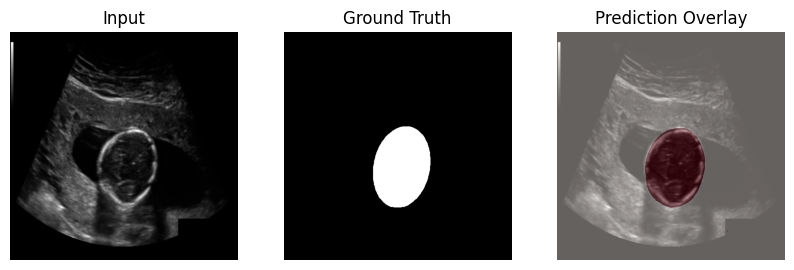

In [23]:
import matplotlib.pyplot as plt

model.eval()

def show_prediction(idx):
    image, mask = val_dataset[idx]
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(image).cpu().squeeze(0)

    pred_bin = (pred > 0.5).float()

    fig, ax = plt.subplots(1, 3, figsize=(10,4))
    ax[0].imshow(image.cpu().squeeze(), cmap='gray')
    ax[0].set_title("Input")

    ax[1].imshow(mask.squeeze(), cmap='gray')
    ax[1].set_title("Ground Truth")

    ax[2].imshow(image.cpu().squeeze(), cmap='gray')
    ax[2].imshow(pred_bin.squeeze(), alpha=0.4, cmap='Reds')
    ax[2].set_title("Prediction Overlay")

    for a in ax: 
        a.axis('off')
    plt.show()

show_prediction(70)


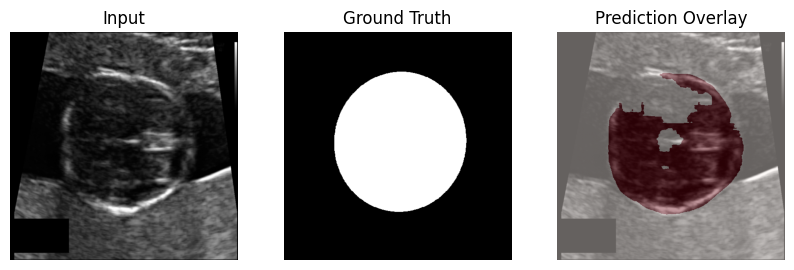

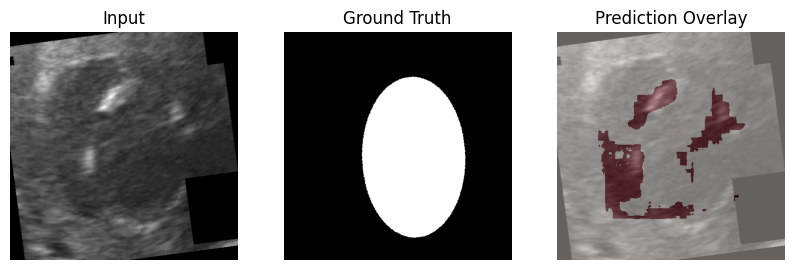

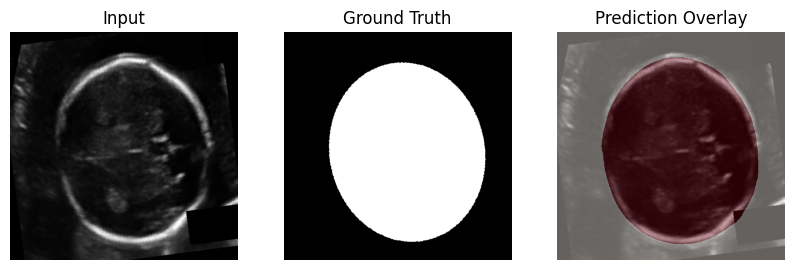

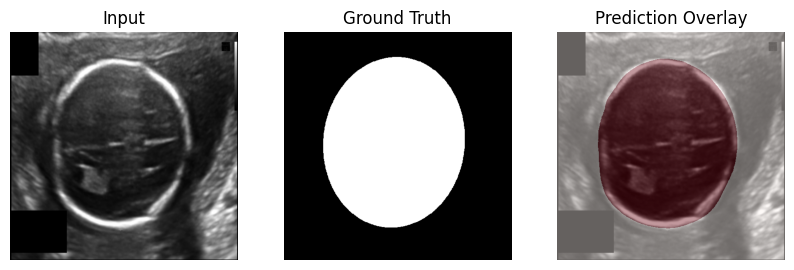

In [24]:
show_prediction(0)
show_prediction(3)
show_prediction(7)
show_prediction(12)


In [25]:
def select_head_contour(cnts, img_shape):
    h, w = img_shape[:2]
    cx, cy = w//2, h//2

    best = None
    best_score = -1

    for c in cnts:
        area = cv2.contourArea(c)
        if area < 2000:   # skip tiny blobs
            continue

        # distance of contour centroid to image center
        M = cv2.moments(c)
        if M["m00"] == 0:
            continue
        x = int(M["m10"]/M["m00"])
        y = int(M["m01"]/M["m00"])
        dist = np.hypot(x-cx, y-cy)

        # compactness score (prefer ellipse-like)
        per = cv2.arcLength(c, True)
        if per == 0:
            continue
        compact = 4*np.pi*area/(per*per)

        # final score: area * compactness / distance
        score = area * compact / (dist+1)

        if score > best_score:
            best = c
            best_score = score

    return best


In [26]:
import cv2, numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# POST-PROCESS + HEAD REGION
# ---------------------------
def postprocess_mask(pred):
    pred = (pred > 0.5).astype(np.uint8) * 255

    # close gaps + smooth interior
    pred = cv2.morphologyEx(pred, cv2.MORPH_CLOSE, np.ones((9,9),np.uint8))
    pred = cv2.medianBlur(pred, 5)

    cnts, _ = cv2.findContours(pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return pred

    h, w = pred.shape
    cx, cy = w//2, h//2

    # choose contour closest to image center (head, not probe rim)
    best = None
    best_score = 1e9

    for c in cnts:
        area = cv2.contourArea(c)
        if area < 2000:   # ignore tiny blobs
            continue

        M = cv2.moments(c)
        if M["m00"] == 0: 
            continue
        
        x = int(M["m10"]/M["m00"])
        y = int(M["m01"]/M["m00"])
        dist = np.hypot(x-cx, y-cy)

        if dist < best_score:
            best = c
            best_score = dist

    mask = np.zeros_like(pred)
    cv2.drawContours(mask, [best], -1, 255, -1)
    return mask


# ---------------------------
# ELLIPSE + AXES
# ---------------------------
def fit_ellipse_and_axes(mask):
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not cnts:
        return None

    cnt = max(cnts, key=cv2.contourArea)
    ellipse = cv2.fitEllipse(cnt)

    (cx, cy), (major, minor), angle = ellipse
    theta = np.deg2rad(angle)

    # unit vectors
    ux, uy = np.cos(theta), np.sin(theta)
    vx, vy = -uy, ux

    # OFD axis (major)
    p1 = (int(cx + ux*major/2), int(cy + uy*major/2))
    p2 = (int(cx - ux*major/2), int(cy - uy*major/2))

    # BPD axis (minor)
    p3 = (int(cx + vx*minor/2), int(cy + vy*minor/2))
    p4 = (int(cx - vx*minor/2), int(cy - vy*minor/2))

    return {
        "ellipse": ellipse,
        "center": (int(cx), int(cy)),
        "ofd": major,
        "bpd": minor,
        "OFD_points": (p1, p2),
        "BPD_points": (p3, p4),
    }


# ---------------------------
# VISUALIZE RESULT
# ---------------------------
def visualize_biometry(image, pred):
    img = (image.squeeze().cpu().numpy()*255).astype(np.uint8)
    pred = pred.squeeze().cpu().numpy()

    mask = postprocess_mask(pred)
    print("Mask shape:", mask.shape, "dtype:", mask.dtype)
    plt.figure(figsize=(4,4))
    plt.imshow(mask, cmap="gray")
    plt.title("Mask passed to ellipse()")
    plt.axis("off")
    plt.show()

    info = fit_ellipse_and_axes(mask)

    if info is None:
        print("No ellipse detected")
        return
    # 🔹 DEBUG PRINTS
    print("Mask shape:", mask.shape)
    print("Ellipse params:", info["ellipse"])
    print("BPD/OFD:", info["bpd"], info["ofd"])
    vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # draw ellipse + axes
    cv2.ellipse(vis, info["ellipse"], (0,255,0), 2)

    p1,p2 = info["OFD_points"]
    p3,p4 = info["BPD_points"]

    cv2.line(vis, p1, p2, (255,0,0), 2)   # OFD (blue)
    cv2.line(vis, p3, p4, (0,0,255), 2)   # BPD (red)

    plt.figure(figsize=(5,5))
    plt.imshow(vis)
    plt.axis("off")
    plt.show()

    print(f"BPD = {info['bpd']:.2f} px   |   OFD = {info['ofd']:.2f} px")

Mask shape: (512, 512) dtype: uint8


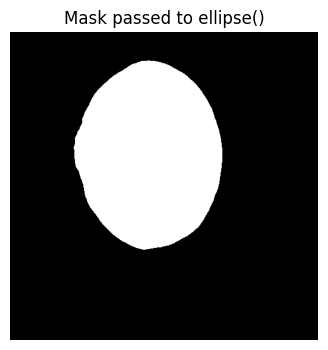

Mask shape: (512, 512)
Ellipse params: ((231.39901733398438, 204.3738250732422), (240.97244262695312, 308.8214111328125), 178.072265625)
BPD/OFD: 308.8214111328125 240.97244262695312


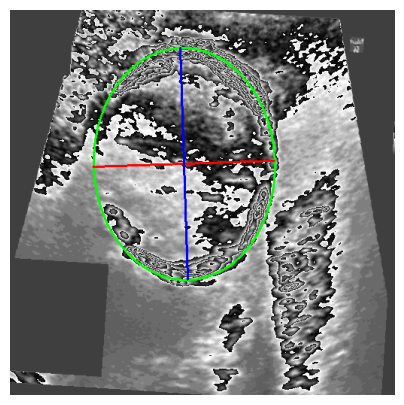

BPD = 308.82 px   |   OFD = 240.97 px


In [27]:
image, _ = val_dataset[1]

with torch.no_grad():
    pred = model(image.unsqueeze(0).to(device)).cpu()

visualize_biometry(image, pred)

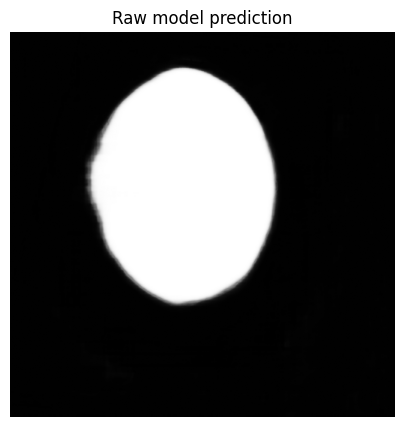

In [28]:
plt.figure(figsize=(5,5))
plt.imshow(pred.squeeze(), cmap="gray")
plt.title("Raw model prediction")
plt.axis("off")
plt.show()


In [29]:
print("Pred shape:", pred.shape)
print("Pred min/max:", pred.min().item(), pred.max().item())


Pred shape: torch.Size([1, 1, 512, 512])
Pred min/max: 0.005064232274889946 0.9999693632125854


In [30]:
print("Hello World")

Hello World


Mask shape: (512, 512) dtype: uint8


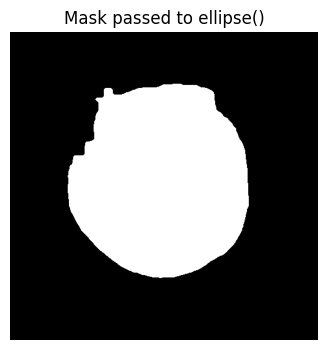

Mask shape: (512, 512)
Ellipse params: ((250.12620544433594, 246.02345275878906), (297.86669921875, 326.7987060546875), 178.03073120117188)
BPD/OFD: 326.7987060546875 297.86669921875


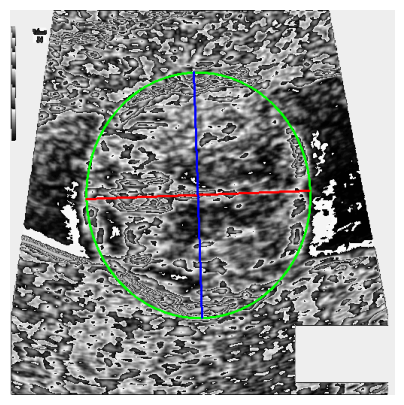

BPD = 326.80 px   |   OFD = 297.87 px
Mask shape: (512, 512) dtype: uint8


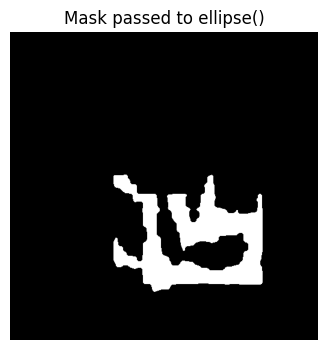

Mask shape: (512, 512)
Ellipse params: ((296.5857849121094, 336.3587646484375), (173.79786682128906, 262.1125793457031), 101.3551025390625)
BPD/OFD: 262.1125793457031 173.79786682128906


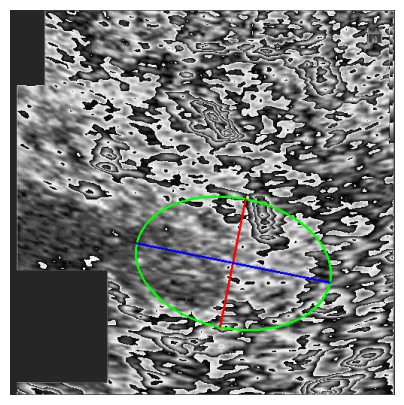

BPD = 262.11 px   |   OFD = 173.80 px
Mask shape: (512, 512) dtype: uint8


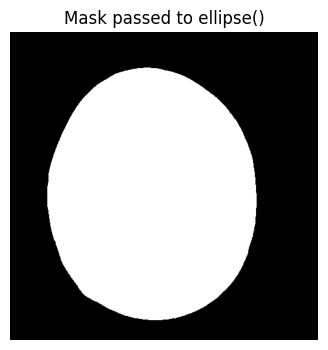

Mask shape: (512, 512)
Ellipse params: ((236.0551300048828, 271.2242736816406), (348.1705017089844, 420.2064208984375), 177.41111755371094)
BPD/OFD: 420.2064208984375 348.1705017089844


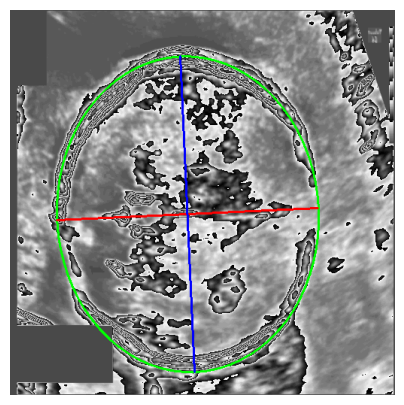

BPD = 420.21 px   |   OFD = 348.17 px
Mask shape: (512, 512) dtype: uint8


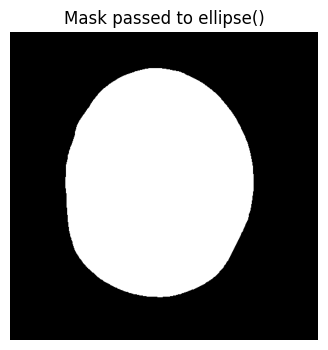

Mask shape: (512, 512)
Ellipse params: ((245.48666381835938, 252.0812530517578), (313.56805419921875, 382.1307678222656), 3.296673536300659)
BPD/OFD: 382.1307678222656 313.56805419921875


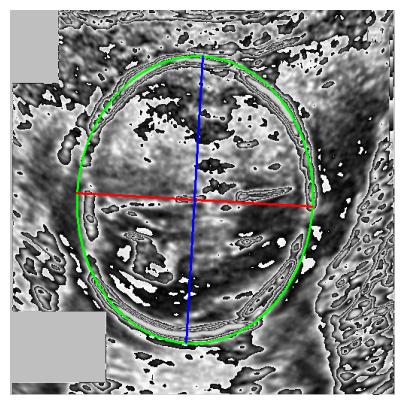

BPD = 382.13 px   |   OFD = 313.57 px


In [31]:
for i in [0, 3, 7, 12]:
    img, _ = val_dataset[i]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device)).cpu()

    visualize_biometry(img, pred)

In [32]:
torch.save(model.state_dict(), "unet_fetal_head_seg.pth")